<a href="https://colab.research.google.com/github/shaistamomin2004-arch/tumordetection.ipynb/blob/main/tumordetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!ls -la ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Jan 15 10:54 .
drwx------ 1 root root 4096 Jan 15 10:54 ..
-rw------- 1 root root   64 Jan 15 10:54 kaggle.json


In [3]:
!kaggle datasets list

ref                                                               title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
neurocipher/heartdisease                                          Heart Disease                                             3491  2025-12-11 15:29:14.327000           2114        283  1.0              
suvidyasonawane/student-academic-placement-performance-dataset    Student Academic Placement Performance Dataset           94469  2026-01-11 02:02:47.837000              0         27  1.0              
neurocipher/student-performance                                   Student Performance                                      49705  2025-12-12 12:06:28.973000           1261        160  1.0     

In [4]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.14G/4.16G [00:59<00:01, 17.0MB/s]
100% 4.16G/4.16G [00:59<00:00, 75.1MB/s]


In [5]:
!unzip -q "brats20-dataset-training-validation.zip" -d "/content/brats20/"

In [6]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         113G   83G   30G  74% /
tmpfs            64M     0   64M   0% /dev
shm             5.7G     0  5.7G   0% /dev/shm
/dev/root       2.0G  1.2G  750M  62% /usr/sbin/docker-init
tmpfs           6.4G  140K  6.4G   1% /var/colab
/dev/sda1       119G   85G   35G  72% /kaggle/input
tmpfs           6.4G     0  6.4G   0% /proc/acpi
tmpfs           6.4G     0  6.4G   0% /proc/scsi
tmpfs           6.4G     0  6.4G   0% /sys/firmware


In [7]:
import os

os.listdir('/content/brats20')

['BraTS2020_ValidationData', 'BraTS2020_TrainingData']

In [8]:
import os

sample = '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
os.listdir(sample)

['BraTS20_Training_001_t1.nii',
 'BraTS20_Training_001_t1ce.nii',
 'BraTS20_Training_001_seg.nii',
 'BraTS20_Training_001_flair.nii',
 'BraTS20_Training_001_t2.nii']

In [9]:
!pip install nibabel

In [10]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
path = '/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii'
img = nib.load(path).get_fdata()
img.shape

(240, 240, 155)

(np.float64(-0.5), np.float64(239.5), np.float64(239.5), np.float64(-0.5))

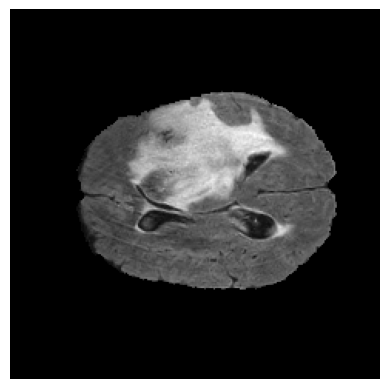

In [11]:
slice_index = 80
plt.imshow(img[:, :, slice_index], cmap='gray')
plt.axis('off')

In [12]:
DATA_DIR = "/content/brats20/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

In [13]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os

case_path = os.path.join(DATA_DIR, "BraTS20_Training_001")

flair = nib.load(os.path.join(case_path, "BraTS20_Training_001_flair.nii")).get_fdata()
t1 = nib.load(os.path.join(case_path, "BraTS20_Training_001_t1.nii")).get_fdata()
t1ce = nib.load(os.path.join(case_path, "BraTS20_Training_001_t1ce.nii")).get_fdata()
t2 = nib.load(os.path.join(case_path, "BraTS20_Training_001_t2.nii")).get_fdata()
seg = nib.load(os.path.join(case_path, "BraTS20_Training_001_seg.nii")).get_fdata()

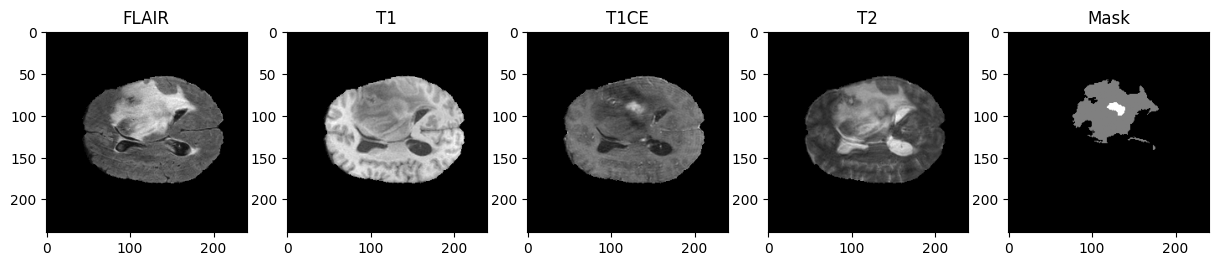

In [14]:
slice_idx = 80

plt.figure(figsize=(15,5))
plt.subplot(1, 5, 1); plt.imshow(flair[:,:,slice_idx], cmap='gray'); plt.title("FLAIR")
plt.subplot(1, 5, 2); plt.imshow(t1[:,:,slice_idx], cmap='gray'); plt.title("T1")
plt.subplot(1, 5, 3); plt.imshow(t1ce[:,:,slice_idx], cmap='gray'); plt.title("T1CE")
plt.subplot(1, 5, 4); plt.imshow(t2[:,:,slice_idx], cmap='gray'); plt.title("T2")
plt.subplot(1, 5, 5); plt.imshow(seg[:,:,slice_idx], cmap='gray'); plt.title("Mask")
plt.show()


In [15]:
def extract_slices(volume, mask):
    slices = []
    for i in range(volume.shape[2]):
        if np.max(mask[:,:,i]) > 0:   # skip empty slices
            slices.append(i)
    return slices


In [16]:
valid_slices = extract_slices(flair, seg)
print("Valid slices:", valid_slices[:10], "... total:", len(valid_slices))

Valid slices: [30, 31, 32, 33, 34, 35, 36, 37, 38, 39] ... total: 83


In [17]:
import os

output_img_dir = "/content/2d_images"
output_mask_dir = "/content/2d_masks"

os.makedirs(output_img_dir, exist_ok=True)
os.makedirs(output_mask_dir, exist_ok=True)

In [18]:
def normalize(img):
    img = img.astype("float32")
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img


In [19]:
import cv2
import numpy as np
import nibabel as nib

import glob

all_cases = sorted(glob.glob(os.path.join(DATA_DIR, "BraTS20_Training_*")))

count = 0

for case in all_cases:
    patient_id = os.path.basename(case)

    if patient_id == "BraTS20_Training_355":
        expected_seg_path = os.path.join(case, patient_id + "_seg.nii")
        if not os.path.exists(expected_seg_path):
            nii_files = [f for f in os.listdir(case) if f.endswith(".nii")]
            known_scans = [f"{patient_id}_flair.nii", f"{patient_id}_t1.nii", f"{patient_id}_t1ce.nii", f"{patient_id}_t2.nii"]
            misnamed_seg_file = ""
            for nii_file in nii_files:
                if nii_file not in known_scans:
                    misnamed_seg_file = nii_file
                    break

            if misnamed_seg_file:
                old_path = os.path.join(case, misnamed_seg_file)
                new_path = expected_seg_path
                os.rename(old_path, new_path)
                print(f"Renamed {misnamed_seg_file} to {os.path.basename(new_path)} for {patient_id}")
            else:
                print(f"Warning: Could not find misnamed segmentation file for {patient_id}")

    try:
        flair = nib.load(os.path.join(case, patient_id + "_flair.nii")).get_fdata()
        seg = nib.load(os.path.join(case, patient_id + "_seg.nii")).get_fdata()
    except OSError as e:
        print(f"Skipping case {patient_id} due to file corruption: {e}")
        continue # Skip to the next case if file is corrupted

    for i in range(seg.shape[2]):
        if np.max(seg[:,:,i]) > 0:  # slice must contain tumor

            img = normalize(flair[:,:,i])
            mask = seg[:,:,i]

            # save image
            cv2.imwrite(f"{output_img_dir}/{patient_id}slice{i}.png", (img*255).astype(np.uint8))

            # save mask
            cv2.imwrite(f"{output_mask_dir}/{patient_id}slice{i}.png", mask.astype(np.uint8))

            count += 1

print(count)

Renamed W39_1998.09.19_Segm.nii to BraTS20_Training_355_seg.nii for BraTS20_Training_355
24422


In [20]:
len(os.listdir("/content/2d_images"))

24422

In [21]:
len(os.listdir("/content/2d_masks"))


24422

In [22]:
files = sorted(os.listdir("/content/2d_images"))
files[-5:]

['BraTS20_Training_369slice95.png',
 'BraTS20_Training_369slice96.png',
 'BraTS20_Training_369slice97.png',
 'BraTS20_Training_369slice98.png',
 'BraTS20_Training_369slice99.png']

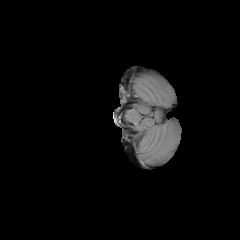

In [23]:
from PIL import Image
import random

img_name = random.choice(os.listdir("/content/2d_images"))
Image.open(f"/content/2d_images/{img_name}")

In [24]:
import cv2
import os

IMG_SIZE = 128

for img_name in os.listdir("/content/2d_images"):
    img_path = f"/content/2d_images/{img_name}"
    mask_path = f"/content/2d_masks/{img_name}"

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    cv2.imwrite(img_path, img)
    cv2.imwrite(mask_path, mask)

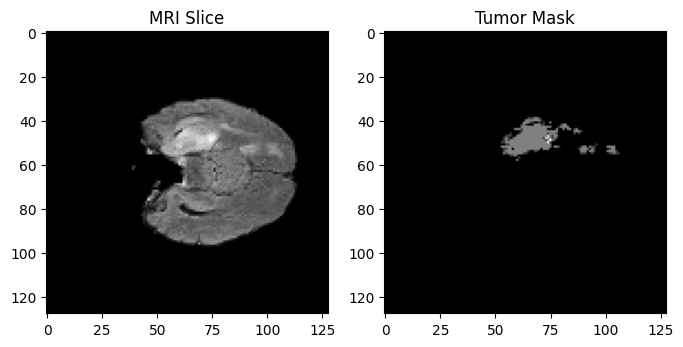

In [25]:
import matplotlib.pyplot as plt
import random
import os
import cv2

# Get a random image name from the directory
img_name_to_display = random.choice(os.listdir("/content/2d_images"))

img = cv2.imread(os.path.join("/content/2d_images", img_name_to_display), 0)
mask = cv2.imread(os.path.join("/content/2d_masks", img_name_to_display), 0)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.title("MRI Slice")
plt.imshow(img, cmap="gray")

plt.subplot(1,2,2)
plt.title("Tumor Mask")
plt.imshow(mask, cmap="gray")

plt.show()

In [26]:
import os
import random
import shutil

# Source folders (already exist)
IMG_DIR = "/content/2d_images"
MASK_DIR = "/content/2d_masks"

# New folders (model-ready)
TRAIN_IMG = "/content/train/images"
TRAIN_MASK = "/content/train/masks"
VAL_IMG = "/content/val/images"
VAL_MASK = "/content/val/masks"

os.makedirs(TRAIN_IMG, exist_ok=True)
os.makedirs(TRAIN_MASK, exist_ok=True)
os.makedirs(VAL_IMG, exist_ok=True)
os.makedirs(VAL_MASK, exist_ok=True)
# List all images
all_files = os.listdir(IMG_DIR)
random.shuffle(all_files)

split_ratio = 0.8
split_index = int(len(all_files) * split_ratio)

train_files = all_files[:split_index]
val_files = all_files[split_index:]

# Copy files (NOT move)
for f in train_files:
    shutil.copy(os.path.join(IMG_DIR, f), os.path.join(TRAIN_IMG, f))
    shutil.copy(os.path.join(MASK_DIR, f), os.path.join(TRAIN_MASK, f))
for f in val_files:
    shutil.copy(os.path.join(IMG_DIR, f), os.path.join(VAL_IMG, f))
    shutil.copy(os.path.join(MASK_DIR, f), os.path.join(VAL_MASK, f))

print("Train images:", len(os.listdir(TRAIN_IMG)))
print("Val images:", len(os.listdir(VAL_IMG)))

Train images: 19537
Val images: 4885


In [27]:
import tensorflow as tf

IMG_SIZE = 128
BATCH_SIZE = 8

def load_image(img_path, mask_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Binary mask (tumor vs background)
    mask = tf.where(mask > 0, 1.0, 0.0)

    return img, mask

In [28]:
def create_dataset(img_dir, mask_dir):
    img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    dataset = dataset.map(lambda x, y: load_image(x, y),
                          num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset

train_dataset = create_dataset(TRAIN_IMG, TRAIN_MASK)
val_dataset = create_dataset(VAL_IMG, VAL_MASK)

augmentation

In [29]:
import tensorflow as tf

def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)

    # Random rotation (0, 90, 180, 270 degrees)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k)
    mask = tf.image.rot90(mask, k)

    return image, mask

In [30]:
train_dataset_aug = train_dataset.map(
    augment,
    num_parallel_calls=tf.data.AUTOTUNE
)

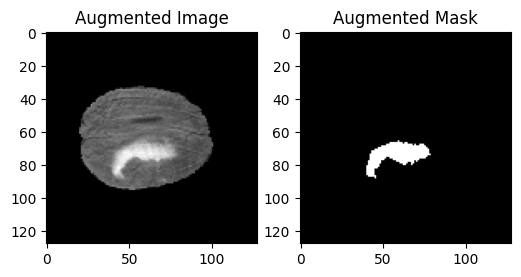

In [31]:
for img, mask in train_dataset_aug.take(1):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Augmented Image")
    plt.imshow(img[0,:,:,0], cmap="gray")
    plt.subplot(1,2,2)
    plt.title("Augmented Mask")
    plt.imshow(mask[0,:,:,0], cmap="gray")
    plt.show()

In [32]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    Conv2DTranspose, concatenate
)
from tensorflow.keras.models import Model

In [33]:
def conv_block(x, filters):
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

In [34]:
def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D()(c1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D()(c2)

    c3 = conv_block(p2, 256)
    p3 = MaxPooling2D()(c3)

    c4 = conv_block(p3, 512)
    p4 = MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 1024)

    # Decoder
    u1 = Conv2DTranspose(512, 2, strides=2, padding="same")(bn)
    u1 = concatenate([u1, c4])
    c5 = conv_block(u1, 512)

    u2 = Conv2DTranspose(256, 2, strides=2, padding="same")(c5)
    u2 = concatenate([u2, c3])
    c6 = conv_block(u2, 256)

    u3 = Conv2DTranspose(128, 2, strides=2, padding="same")(c6)
    u3 = concatenate([u3, c2])
    c7 = conv_block(u3, 128)

    u4 = Conv2DTranspose(64, 2, strides=2, padding="same")(c7)
    u4 = concatenate([u4, c1])
    c8 = conv_block(u4, 64)

    # Output (Binary segmentation)
    outputs = Conv2D(1, 1, activation="sigmoid")(c8)

    model = Model(inputs, outputs)
    return model

In [35]:
model = build_unet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8,      │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
import tensorflow as tf

bce = tf.keras.losses.BinaryCrossentropy()

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * bce(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

only for one time

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "unet_best_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    )
]


connecting drive [imp]

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


For Model Load(no need to run)

In [ ]:
EPOCHS = 5

history = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 405s 154ms/step - dice_coefficient: 0.4145 - loss: 0.3506 - val_dice_coefficient: 0.7110 - val_loss: 0.1707
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 357s 146ms/step - dice_coefficient: 0.7144 - loss: 0.1622 - val_dice_coefficient: 0.7611 - val_loss: 0.1411
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 357s 146ms/step - dice_coefficient: 0.7497 - loss: 0.1408 - val_dice_coefficient: 0.7798 - val_loss: 0.1310
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.7589 - loss: 0.1354 - val_dice_coefficient: 0.7317 - val_loss: 0.1636
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 357s 146ms/step - dice_coefficient: 0.7674 - loss: 0.1309 - val_dice_coefficient: 0.8025 - val_loss: 0.1163


prediction

In [ ]:
import numpy as np

# Take one sample from validation set
for images, masks in val_dataset.take(1):
    test_img = images[0]
    true_mask = masks[0]

pred_mask = model.predict(tf.expand_dims(test_img, axis=0))[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


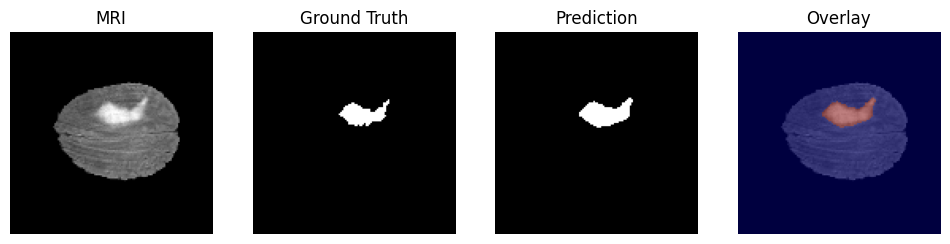

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(test_img[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(true_mask[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred_mask[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(test_img[:,:,0], cmap="gray")
plt.imshow(pred_mask[:,:,0], cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf

# Take another sample from validation set
# To get a different sample each time, we can skip some elements or re-create the iterator
for images, masks in val_dataset.shuffle(buffer_size=1000).take(1):
    test_img_new = images[0]
    true_mask_new = masks[0]

pred_mask_new = model.predict(tf.expand_dims(test_img_new, axis=0))[0]
pred_mask_new = (pred_mask_new > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


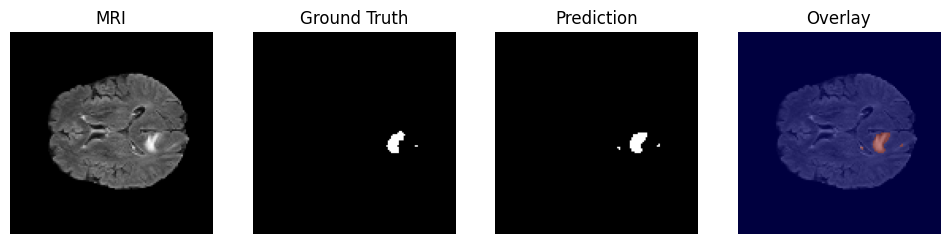

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(test_img_new[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(true_mask_new[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred_mask_new[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(test_img_new[:,:,0], cmap="gray")
plt.imshow(pred_mask_new[:,:,0], cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

for changing images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Change the slice number here
new_img_name = "BraTS20_Training_002slice50.png" # Changed slice from 90 to 80

new_img_path = os.path.join("/content/2d_images", new_img_name)
new_mask_path = os.path.join("/content/2d_masks", new_img_name)

# Read image and mask
img = cv2.imread(new_img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)

# Add a check to ensure image was loaded successfully
if img is None:
    print(f"Error: Image file not found or could not be loaded: {new_img_path}")
    print("Please check the filename and ensure it exists in the /content/2d_images directory.")
else:
    # Resize to model input size (128x128)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Normalize image to 0-1 range
    img_norm = img_resized / 255.0

    # Add batch and channel dimensions for model input (Batch_Size, Height, Width, Channels)
    img_input_new_slice = img_norm[np.newaxis, ..., np.newaxis]

    print(f"Processing new slice: {new_img_name}")


Processing new slice: BraTS20_Training_002slice50.png


In [ ]:
import tensorflow as tf

pred_mask_new_slice = model.predict(img_input_new_slice)[0]
pred_mask_new_slice = (pred_mask_new_slice > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


example

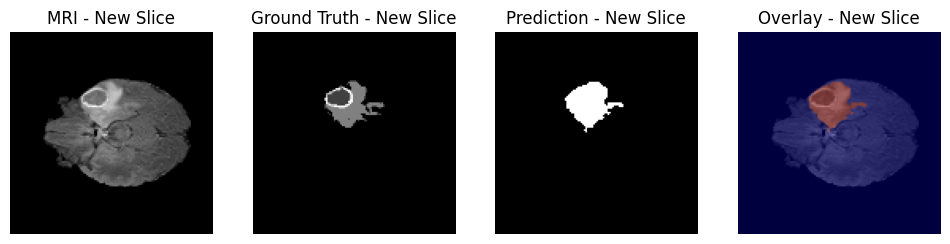

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI - New Slice")
plt.imshow(img_norm[:,:], cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth - New Slice")
plt.imshow(mask_resized[:,:], cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction - New Slice")
plt.imshow(pred_mask_new_slice[:,:,0], cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay - New Slice")
plt.imshow(img_norm[:,:], cmap="gray")
plt.imshow(pred_mask_new_slice[:,:,0], cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

In [ ]:
model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.7915 - loss: 0.1168 - val_dice_coefficient: 0.8357 - val_loss: 0.0980
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.7948 - loss: 0.1147 - val_dice_coefficient: 0.8435 - val_loss: 0.0924
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.7930 - loss: 0.1158 - val_dice_coefficient: 0.8432 - val_loss: 0.0927
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.8002 - loss: 0.1117 - val_dice_coefficient: 0.8451 - val_loss: 0.0920
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 344s 141ms/step - dice_coefficient: 0.8003 - loss: 0.1118 - val_dice_coefficient: 0.8437 - val_loss: 0.0927


In [ ]:
import numpy as np

# Take one sample from validation set
for images, masks in val_dataset.take(1):
    test_img = images[0]
    true_mask = masks[0]

pred_mask = model.predict(tf.expand_dims(test_img, axis=0))[0]
pred_mask = (pred_mask > 0.5).astype(np.uint8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

In [ ]:
history_additional = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 417s 158ms/step - dice_coefficient: 0.4138 - loss: 0.3565 - val_dice_coefficient: 0.6818 - val_loss: 0.1937
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.7004 - loss: 0.1708 - val_dice_coefficient: 0.7530 - val_loss: 0.1486
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.7279 - loss: 0.1539 - val_dice_coefficient: 0.7631 - val_loss: 0.1414
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.7477 - loss: 0.1421 - val_dice_coefficient: 0.7947 - val_loss: 0.1203
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 370s 152ms/step - dice_coefficient: 0.7572 - loss: 0.1366 - val_dice_coefficient: 0.8106 - val_loss: 0.1133


In [ ]:
history_additional = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7685 - loss: 0.1299 - val_dice_coefficient: 0.8121 - val_loss: 0.1118
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7726 - loss: 0.1275 - val_dice_coefficient: 0.8279 - val_loss: 0.1012
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7780 - loss: 0.1243 - val_dice_coefficient: 0.8304 - val_loss: 0.1003
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7831 - loss: 0.1216 - val_dice_coefficient: 0.8254 - val_loss: 0.1038
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7841 - loss: 0.1213 - val_dice_coefficient: 0.8401 - val_loss: 0.0944


In [ ]:
history_additional = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=5
)

Epoch 1/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 372s 152ms/step - dice_coefficient: 0.7893 - loss: 0.1181 - val_dice_coefficient: 0.8364 - val_loss: 0.0959
Epoch 2/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.7928 - loss: 0.1159 - val_dice_coefficient: 0.8409 - val_loss: 0.0932
Epoch 3/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7932 - loss: 0.1159 - val_dice_coefficient: 0.8390 - val_loss: 0.0952
Epoch 4/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7971 - loss: 0.1136 - val_dice_coefficient: 0.8405 - val_loss: 0.0942
Epoch 5/5
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 354s 145ms/step - dice_coefficient: 0.7998 - loss: 0.1120 - val_dice_coefficient: 0.8427 - val_loss: 0.0930


In [ ]:
history_additional = model.fit(
    train_dataset_aug,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 356s 146ms/step - dice_coefficient: 0.7989 - loss: 0.1126 - val_dice_coefficient: 0.8553 - val_loss: 0.0848
Epoch 2/3
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.8026 - loss: 0.1104 - val_dice_coefficient: 0.8440 - val_loss: 0.0922
Epoch 3/3
2443/2443 ━━━━━━━━━━━━━━━━━━━━ 355s 145ms/step - dice_coefficient: 0.8049 - loss: 0.1092 - val_dice_coefficient: 0.8527 - val_loss: 0.0865


### Plotting Training

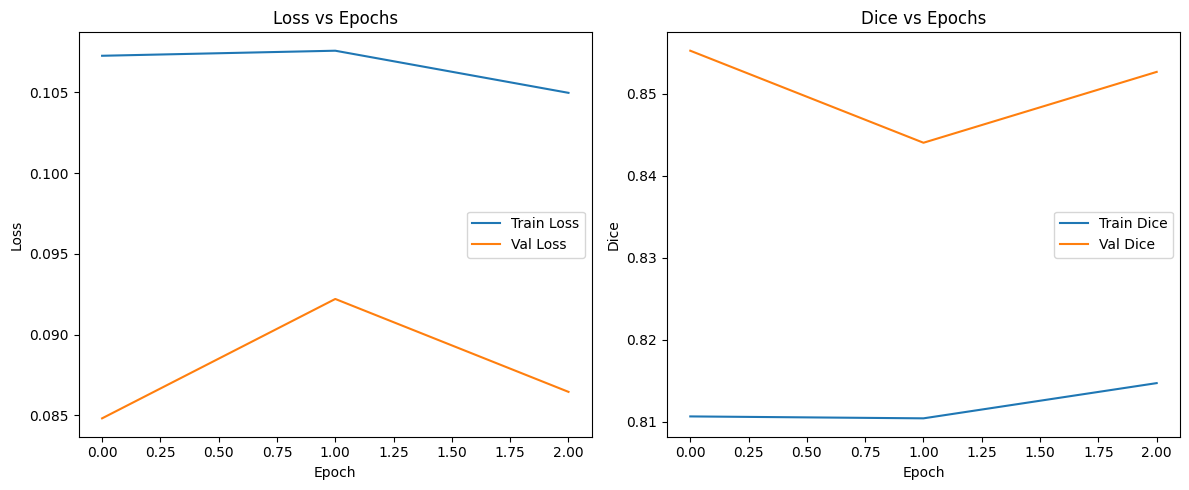

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history_additional.history['loss'], label='Train Loss')
plt.plot(history_additional.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

# Dice
plt.subplot(1,2,2)
plt.plot(history_additional.history['dice_coefficient'], label='Train Dice')
plt.plot(history_additional.history['val_dice_coefficient'], label='Val Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.evaluate(val_dataset)

611/611 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - dice_coefficient: 0.8355 - loss: 0.0949


[0.08645736426115036, 0.8526803851127625]

In [ ]:
plt.savefig("training_curves.png", dpi=300)
print("✅ Training curves saved")

✅ Training curves saved


<Figure size 640x480 with 0 Axes>

In [ ]:
from google.colab import files
files.download("training_curves.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
results = model.evaluate(val_dataset, verbose=1)
print(f"Validation Loss: {results[0]:.4f}")
print(f"Validation Dice: {results[1]:.4f}")

611/611 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - dice_coefficient: 0.8355 - loss: 0.0949
Validation Loss: 0.0865
Validation Dice: 0.8527


In [ ]:
model.save("/content/drive/MyDrive/unet_FINAL_GOOD.keras")

In [ ]:
for images, masks in val_dataset.take(1):
    img = images[0]
    true_mask = masks[0]

In [ ]:
pred = model.predict(img[None, ...])
pred_binary = (pred[0, :, :, 0] > 0.5).astype("float32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


In [ ]:
img_norm = img[:, :, 0]
mask_norm = true_mask[:, :, 0]

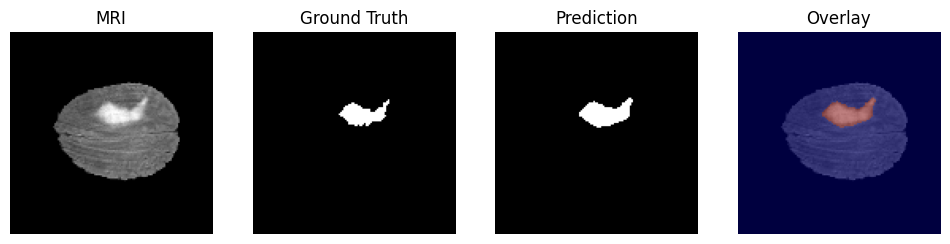

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI")
plt.imshow(img_norm, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth")
plt.imshow(mask_norm, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Prediction")
plt.imshow(pred_binary, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(img_norm, cmap="gray")
plt.imshow(pred_binary, cmap="jet", alpha=0.5)
plt.axis("off")

plt.savefig("final_prediction.png", dpi=300)
plt.show()

In [ ]:
for images, masks in val_dataset.take(1):
    img = images[0]
    true_mask = masks[0]

# Ensure same channel
img_norm = img[:, :, 0]
mask_norm = true_mask[:, :, 0]

In [ ]:
pred = model.predict(img[None, ...])
pred_prob = pred[0, :, :, 0]
pred_binary = (pred_prob > 0.35).astype("float32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


model loading

In [ ]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/unet_FINAL_GOOD.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "combined_loss": combined_loss
    }
)

print("✅ Model loaded")


✅ Model loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

model.save("/content/drive/MyDrive/unet_FINAL_GOOD.keras")

In [ ]:
print('Evaluating the loaded model on the validation dataset...')

# Evaluate the model on the validation dataset
val_loss, val_dice = model.evaluate(val_dataset)

print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Dice Coefficient: {val_dice:.4f}')

Evaluating the loaded model on the validation dataset...
611/611 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - dice_coefficient: 0.8355 - loss: 0.0949
Validation Loss: 0.0865
Validation Dice Coefficient: 0.8527


In [ ]:
model.save("/content/drive/MyDrive/unet_FINAL_GOOD.keras")

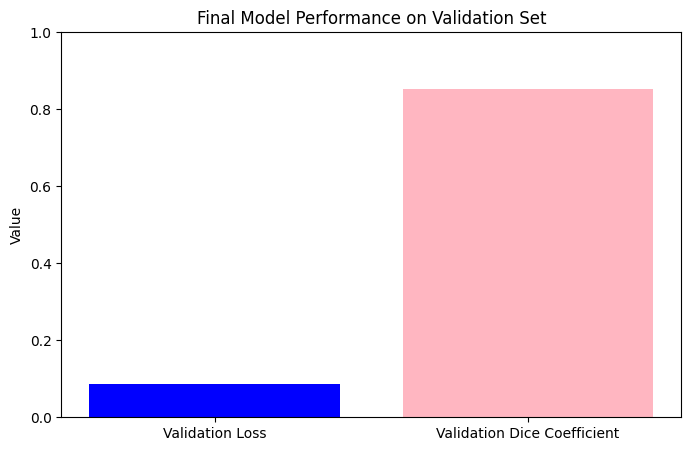

In [ ]:
import matplotlib.pyplot as plt

metrics = {'Validation Loss': val_loss, 'Validation Dice Coefficient': val_dice}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

plt.figure(figsize=(8, 5))
plt.bar(metric_names, metric_values, color=['blue', 'lightpink'])
plt.ylabel('Value')
plt.title('Final Model Performance on Validation Set')
plt.ylim(0, 1) # Metrics like loss and dice are usually between 0 and 1
plt.show()

In [ ]:
plt.savefig("/content/drive/MyDrive/final_validation_metrics.png")

<Figure size 640x480 with 0 Axes>

post-processing

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Example image & mask (change slice number if needed)
# Corrected filename format
img_path = "/content/2d_images/BraTS20_Training_001slice56.png"
mask_path = "/content/2d_masks/BraTS20_Training_001slice56.png"

# Read image
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Add a check to ensure images were loaded successfully
if img is None or mask is None:
    print(f"Error: Image or mask file not found at {img_path} or {mask_path}")
    print("Please check the filename and ensure it exists in the /content/2d_images and /content/2d_masks directories.")
else:
    # Resize to model input size
    img_resized = cv2.resize(img, (128, 128))
    mask_resized = cv2.resize(mask, (128, 128))

    # Normalize image
    img_norm = img_resized / 255.0

    # Add batch + channel dimensions
    img_input = img_norm[np.newaxis, ..., np.newaxis]
    print(f"Successfully loaded and processed {img_path}")


Successfully loaded and processed /content/2d_images/BraTS20_Training_001slice56.png


In [ ]:
pred_mask = model.predict(img_input)

# Remove batch & channel dimensions
pred_mask = pred_mask[0, :, :, 0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


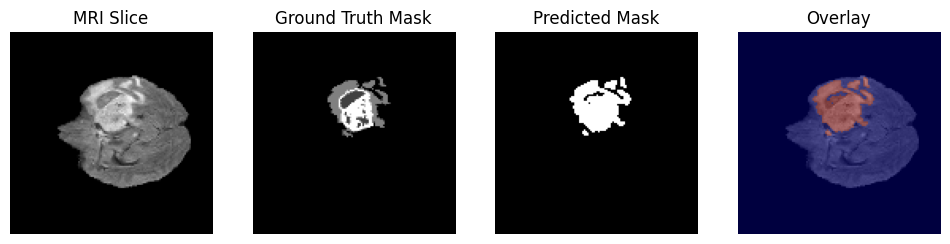

In [ ]:
plt.figure(figsize=(12,4))

# Binarize the predicted mask (e.g., threshold at 0.5)
pred_binary = (pred_mask > 0.5).astype(np.uint8)

plt.subplot(1,4,1)
plt.title("MRI Slice")
plt.imshow(img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth Mask")
plt.imshow(mask_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Predicted Mask")
plt.imshow(pred_binary, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(img_resized, cmap="gray")
plt.imshow(pred_binary, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

In [ ]:
print(pred_mask.min(), pred_mask.max())

3.5839747e-18 0.9999976


In [ ]:
cv2.imwrite(
    "/content/drive/MyDrive/predicted_mask.png",
    pred_binary * 255
)


True

In [39]:
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/unet_FINAL_GOOD.keras",
    custom_objects={
        "dice_coefficient": dice_coefficient,
        "combined_loss": combined_loss
    }
)

print("✅ Model loaded")

✅ Model loaded


In [40]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=combined_loss,
    metrics=[dice_coefficient]
)

post-processing

In [41]:
def predict_and_visualize(model, img_path, mask_path=None):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # -----------------------------
    # 1. LOAD IMAGE
    # -----------------------------
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {img_path}")

    img_resized = cv2.resize(img, (128,128))
    img_norm = img_resized / 255.0
    img_input = img_norm[np.newaxis, ..., np.newaxis]

    # -----------------------------
    # 2. MODEL PREDICTION
    # -----------------------------
    pred = model.predict(img_input, verbose=0)[0, :, :, 0]

    # Threshold
    pred_binary = (pred > 0.5).astype(np.uint8)

    # -----------------------------
    # 3. POST-PROCESSING
    # -----------------------------
    kernel = np.ones((3,3), np.uint8)
    pred_binary = cv2.morphologyEx(pred_binary, cv2.MORPH_OPEN, kernel)
    pred_binary = cv2.morphologyEx(pred_binary, cv2.MORPH_CLOSE, kernel)

    # Keep largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(pred_binary, connectivity=8)
    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        pred_binary = (labels == largest_label).astype(np.uint8)

    # -----------------------------
    # 4. VISUALIZATION
    # -----------------------------
    plt.figure(figsize=(14,4))

    plt.subplot(1,4,1)
    plt.title("MRI Slice")
    plt.imshow(img_resized, cmap="gray")
    plt.axis("off")

    if mask_path:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (128,128))
        plt.subplot(1,4,2)
        plt.title("Ground Truth")
        plt.imshow(mask, cmap="gray")
        plt.axis("off")

    plt.subplot(1,4,3)
    plt.title("Predicted Mask")
    plt.imshow(pred_binary, cmap="gray")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.title("Overlay")
    plt.imshow(img_resized, cmap="gray")
    plt.imshow(pred_binary, cmap="Reds", alpha=0.4)
    plt.axis("off")

    plt.show()

    return pred_binary

In [42]:
## Colored Overlay Output

def overlay_mask(image, mask):
    import numpy as np
    overlay = np.zeros((*image.shape, 3), dtype=np.uint8)
    overlay[:,:,0] = mask * 150  # dark red tumor (was 255 for red)
    return cv2.addWeighted(
        cv2.cvtColor(image, cv2.COLOR_GRAY2RGB),
        0.7,
        overlay,
        0.3,
        0
    )

In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# You can choose a random image, or specify one by name
# new_img_name = random.choice(os.listdir("/content/2d_images"))
new_img_name = "BraTS20_Training_002slice70.png" # Changed to a different image for a new example

new_img_path = os.path.join("/content/2d_images", new_img_name)
new_mask_path = os.path.join("/content/2d_masks", new_img_name)

# Read image and mask
img = cv2.imread(new_img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(new_mask_path, cv2.IMREAD_GRAYSCALE)

# Add a check to ensure images were loaded successfully
if img is None or mask is None:
    print(f"Error: Image or mask file not found at {new_img_path} or {new_mask_path}")
    print("Please check the filename and ensure it exists in the /content/2d_images and /content/2d_masks directories.")
else:
    # Resize to model input size (128x128)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    # Normalize image to 0-1 range
    img_norm = img_resized / 255.0

    # Add batch and channel dimensions for model input (Batch_Size, Height, Width, Channels)
    img_input = img_norm[np.newaxis, ..., np.newaxis]

    print(f"Processing: {new_img_name}")

Processing: BraTS20_Training_002slice70.png


In [66]:
pred_mask = model.predict(img_input)

# Remove batch & channel dimensions to get a 2D mask
pred_mask = pred_mask[0, :, :, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


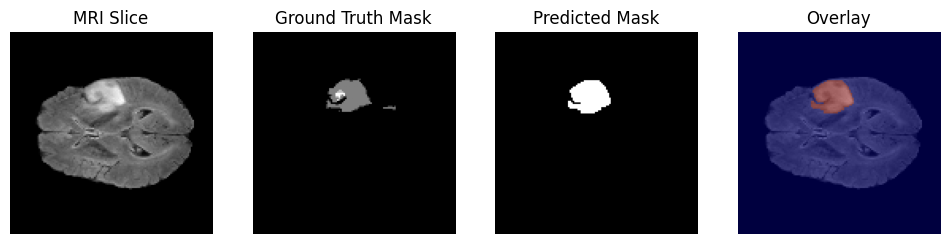

In [67]:
plt.figure(figsize=(12,4))

# Binarize the predicted mask using a threshold (e.g., 0.5)
pred_binary = (pred_mask > 0.5).astype(np.uint8)

plt.subplot(1,4,1)
plt.title("MRI Slice")
plt.imshow(img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth Mask")
plt.imshow(mask_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Predicted Mask")
plt.imshow(pred_binary, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(img_resized, cmap="gray")
plt.imshow(pred_binary, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

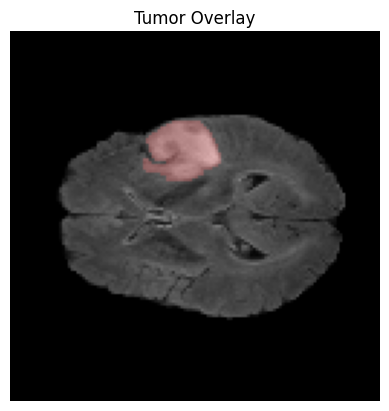

In [68]:
## Prediction

overlay_img = overlay_mask(img_resized, pred_binary)
plt.imshow(overlay_img)
plt.title("Tumor Overlay")
plt.axis("off")

In [69]:
print(pred_mask.min(), pred_mask.max())

1.26134645e-26 0.9999995


In [70]:
print(img_resized.shape)
print(mask_resized.shape)
print(pred_binary.shape)

(128, 128)
(128, 128)
(128, 128)


In [71]:
val_loss, val_dice = model.evaluate(val_dataset)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Dice: {val_dice:.4f}")

611/611 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - dice_coefficient: 0.8444 - loss: 0.0908
Final Validation Loss: 0.0845
Final Validation Dice: 0.8573


In [73]:
model.save("/content/drive/MyDrive/brain_tumor_unet_FINAL.keras")


In [74]:
import tensorflow as tf

model = tf.keras.models.load_model(
    "/content/drive/MyDrive/brain_tumor_unet_FINAL.keras",
    custom_objects={"dice_coefficient": dice_coefficient, "combined_loss": combined_loss}
)

print("✅ Model loaded successfully")

✅ Model loaded successfully


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 94 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [77]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128

new_img_name = "BraTS20_Training_153slice38.png"  # Corrected filename

img_path = os.path.join("/content/2d_images", new_img_name)
mask_path = os.path.join("/content/2d_masks", new_img_name)

In [78]:
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

# Add a check to ensure images were loaded successfully
if img is None or mask is None:
    print(f"Error: Image or mask file not found at {img_path} or {mask_path}")
    print("Please check the filename and ensure it exists in the /content/2d_images and /content/2d_masks directories.")
else:
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask_resized = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

    img_norm = img_resized / 255.0
    img_input = img_norm[np.newaxis, ..., np.newaxis]


In [79]:
pred_mask = model.predict(img_input)

# Remove batch & channel dimensions to get a 2D mask
pred_mask = pred_mask[0, :, :, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 887ms/step


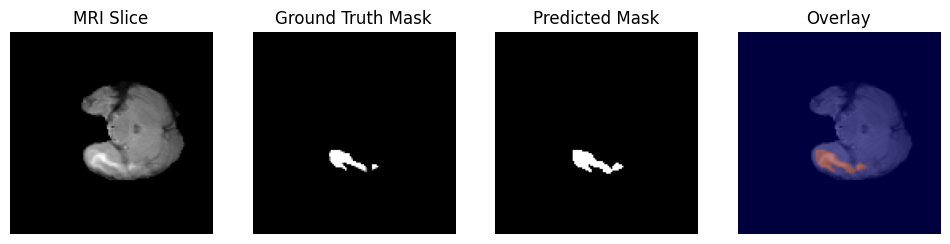

In [80]:
plt.figure(figsize=(12,4))

# Binarize the predicted mask using a threshold (e.g., 0.5)
pred_binary = (pred_mask > 0.5).astype(np.uint8)

plt.subplot(1,4,1)
plt.title("MRI Slice")
plt.imshow(img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth Mask")
plt.imshow(mask_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Predicted Mask")
plt.imshow(pred_binary, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(img_resized, cmap="gray")
plt.imshow(pred_binary, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()

(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

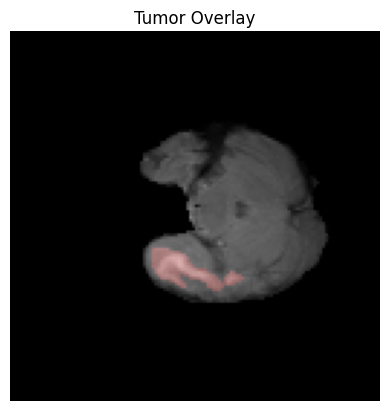

In [81]:
## Prediction

overlay_img = overlay_mask(img_resized, pred_binary)
plt.imshow(overlay_img)
plt.title("Tumor Overlay")
plt.axis("off")

In [83]:
print("Mask unique values:", np.unique(mask))


Mask unique values: [0 1 2]


In [84]:
mask_binary = (mask_resized > 0).astype(np.uint8)

In [85]:
print("GT mask unique:", np.unique(mask_resized))
print("Binary GT unique:", np.unique(mask_binary))

GT mask unique: [0 1 2]
Binary GT unique: [0 1]


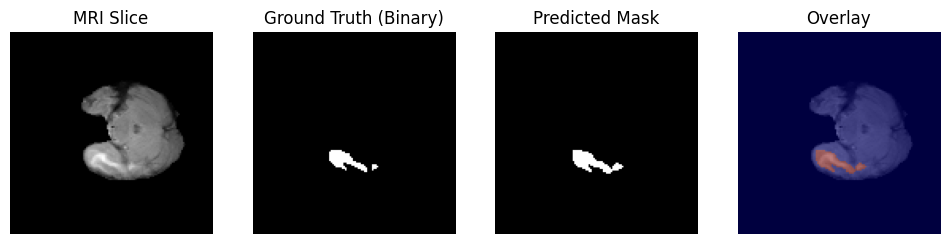

In [88]:
plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("MRI Slice")
plt.imshow(img_resized, cmap="gray")
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Ground Truth (Binary)")
plt.imshow(mask_binary, cmap="gray")
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Predicted Mask")
plt.imshow(pred_binary, cmap="gray")
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Overlay")
plt.imshow(img_resized, cmap="gray")
plt.imshow(pred_binary, cmap="jet", alpha=0.5)
plt.axis("off")

plt.show()